Notebook putting together concepts from all modeling notebook to construct final model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm
%matplotlib inline

In [64]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold,cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import RFE, f_regression, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [ ]:
import sys
sys.path.append('./lib')
from hello import print_hello

In [3]:
listings = pd.read_csv('Datasources/listings_augmented/listings_augmented_2018-05-23_V5.csv',low_memory=False)
listings = listings.drop(listings.index[4216:4219])
listings.index = [i for i in range(len(listings))]

In [4]:
#Excluded variables from the featuresExploration notebook
%store -r excluded

In [5]:
cols = [i for i in listings.columns if i not in excluded]
X = listings[cols]

In [6]:
def scale_data(X):
    return pd.DataFrame(preprocessing.scale(X),columns = X.columns)

In [7]:
def normalize_data(X):
    return pd.DataFrame(preprocessing.normalize(X),columns = X.columns)

In [8]:
X[X.columns[X.isnull().any()]].isnull().sum()

bathrooms    8
bedrooms     3
beds         3
dtype: int64

In [9]:
X = X.fillna(X.mean())

In [10]:
X_scaled = scale_data(X)
X_normed = normalize_data(X)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [11]:
y_scaled = X_scaled['price_y'].fillna(X_scaled['price_y'].mean())
X_scaled = X_scaled[X_scaled.columns.drop(X_scaled[list(X_scaled.filter(regex='price'))])]

In [12]:
y_normed = X_normed['price_y'].fillna(X_normed['price_y'].mean())
X_normed = X_normed[X_normed.columns.drop(X_normed[list(X_normed.filter(regex='price'))])]

Step1: Simple Model with Linear Regression

In [13]:
def eval_metrics(scores):
    print 'Training R2 Mean: ',scores['train_r2'].mean()
    print 'Validation R2 Mean: ',scores['test_r2'].mean()
    print 'Validation R2 STdev: ',scores['test_r2'].std()
    print '--'
    print 'Training RMSE Mean: ', np.sqrt(-scores['train_neg_mean_squared_error'].mean())
    print 'Validation RMSE Mean: ', np.sqrt(-scores['test_neg_mean_squared_error'].mean())
    print 'Validation RMSE STdev: ',scores['test_neg_mean_squared_error'].std()
    print '--'
    print 'Training MAE Mean: ', -scores['train_neg_mean_absolute_error'].mean()
    print 'Validation MAE Mean: ', -scores['test_neg_mean_absolute_error'].mean()
    print 'Validation MAE STdev: ',scores['test_neg_mean_absolute_error'].std()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_normed,y_normed, test_size=0.3, random_state=42)

In [15]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)

In [16]:
lin_reg.fit(X_train, y_train)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
predictions_train = lin_reg.predict(X_train)

In [18]:
print 'Training R2: ',r2_score(y_train, predictions_train)
print 'Training RMSE: ',np.sqrt(mean_squared_error(y_train, predictions_train))
print 'Training MAE: ',mean_absolute_error(y_train, predictions_train)

Training R2:  0.8052328756053723
Training RMSE:  0.020178039250162327
Training MAE:  0.014932284628758612


In [19]:
tree_reg = DecisionTreeRegressor()

In [20]:
tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [21]:
predictions_train = tree_reg.predict(X_train)

In [22]:
print 'Training R2: ',r2_score(y_train, predictions_train)
print 'Training RMSE: ',np.sqrt(mean_squared_error(y_train, predictions_train))
print 'Training MAE: ',mean_absolute_error(y_train, predictions_train)

Training R2:  0.9999942384987529
Training RMSE:  0.00010974606730725905
Training MAE:  5.253055300833797e-05


Using Cross Validation

In [23]:
scores_lin = cross_validate(lin_reg, X_train, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [24]:
scores_tree = cross_validate(tree_reg, X_train, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [26]:
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_lin)
print '----'
print '----'
print 'Evaluation Metrics for Tree Regression with CV: '
eval_metrics(scores_tree)

Evaluation Metrics for Tree Regression with CV: 
Training R2 Mean:  0.9999944364550997
Validation R2 Mean:  0.6584505835841109
Validation R2 STdev:  0.06756815687093944
--
Training RMSE Mean:  0.00010783459029090394
Validation RMSE Mean:  0.02650695889459948
Validation RMSE STdev:  0.00010055107975661094
--
Training MAE Mean:  5.142451388893966e-05
Validation MAE Mean:  0.01784008374166647
Validation MAE STdev:  0.0008919983064126409
----
----
Evaluation Metrics for Linear Regression with CV: 
Training R2 Mean:  0.8065661064488016
Validation R2 Mean:  0.770063726322997
Validation R2 STdev:  0.05023369370165097
--
Training RMSE Mean:  0.020106392199692652
Validation RMSE Mean:  0.02169786741476903
Validation RMSE STdev:  6.930837295680416e-05
--
Training MAE Mean:  0.014897680453666773
Validation MAE Mean:  0.015711168672384816
Validation MAE STdev:  0.0008798144139304789


In [86]:
#plots the RMSE for train and validation as a function of the number of instances in the training set
def plot_rmse_instances(clf, X_train, y_train):

    train_errors, validation_errors = [],[]
    
    n = 2
    
    for i in range(n+1,len(X_train)):
        
        cv_results = cross_validate(clf,X_train[:i],y_train[:i],
                                   scoring='neg_mean_squared_error',
                                   cv=n)
        train_score = np.sqrt(-cv_results['train_score'].mean())
        val_score = np.sqrt(-cv_results['test_score'].mean())
        
        train_errors.append(train_score)
        validation_errors.append(val_score)    
    
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(validation_errors), "b-", linewidth=2, label='validation')
    plt.xlabel('Number of Instances')
    plt.ylabel('RMSE')
    plt.title('Train and Val RMSE\'s as a Function of Number of Instances')
    plt.show()    

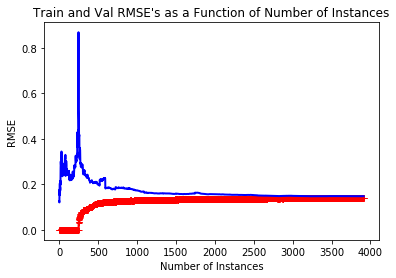

In [87]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, 
                                        normalize=False)
plot_rmse_instances(lin_reg, X_train, y_train)

In [119]:
#Plot the RMSE for training and validation as a function of the number of features used
#ranked features is a list of features sorted by importance - descending
def plot_rmse_features(clf, X_train, y_train, ranked_features):
    
    X_train, X_val, y_train, y_val = train_test_split(X_train[ranked_features], y_train, test_size=0.3)
    
    train_errors, validation_errors = [],[]
    
    for i in range(3,len(ranked_features)):
        clf.fit(X_train.ix[:,2:i],y_train)
        y_train_predict = clf.predict(X_train.ix[:,2:i])
        y_val_predict = clf.predict(X_val.ix[:,2:i])
        train_errors.append(mean_squared_error(y_train_predict, y_train))
        validation_errors.append(mean_squared_error(y_val_predict, y_val))
    
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(validation_errors), "b-", linewidth=2, label='validation')
    plt.xlabel('Number of Features')
    plt.ylabel('RMSE')
    plt.title('Train and Val RMSE\'s as a Function of Number of Features')
    plt.show()    

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


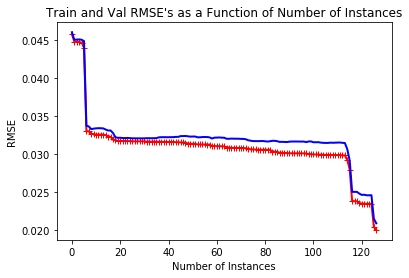

In [143]:
plot_rmse_features(lin_reg, X_normed, y_normed,X_normed.columns)

In [135]:
estimator = linear_model.LinearRegression(fit_intercept=True, normalize=False)
selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_normed, y_normed)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring='neg_mean_squared_error', step=1, verbose=0)

In [136]:
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 119


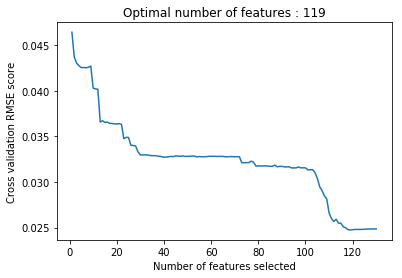

In [137]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation RMSE score")
plt.title("Optimal number of features : %d" % selector.n_features_)
plt.plot(range(1, len(selector.grid_scores_) + 1), np.sqrt(-selector.grid_scores_))
plt.show()

In [140]:
X_new = selector.transform(X_normed)

In [148]:
selector.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,
        1,  3,  1,  2,  8,  1,  1,  1,  1,  1,  1,  1,  1,  9,  1,  1,  1,
        1,  1, 11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  7,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 12,
        1,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  5,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, 10,  1,  1,  1])

Now let's try Linear Regression with CV again and let's see if we have any improvements with the transformed version of X

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y_normed, test_size=0.3, random_state=42)

In [142]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
scores_lin = cross_validate(lin_reg, X_train, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_lin)

Evaluation Metrics for Linear Regression with CV: 
Training R2 Mean:  0.8055686883182986
Validation R2 Mean:  0.7708664275853888
Validation R2 STdev:  0.049717889359141614
--
Training RMSE Mean:  0.020158185017961117
Validation RMSE Mean:  0.02166134059759201
Validation RMSE STdev:  6.855200939550681e-05
--
Training MAE Mean:  0.01492765077950654
Validation MAE Mean:  0.015699674670215432
Validation MAE STdev:  0.0008682727118683468


The Validation Metrics have all (slightly) improved!

Now trying out RandomForest Regression

In [26]:
for_reg = RandomForestRegressor()

In [27]:
for_reg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
scores_lin = cross_validate(for_reg, X_train, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [29]:
print 'Evaluation Metrics for Random Forest Regression with CV: '
eval_metrics(scores_lin)

Evaluation Metrics for Random Forest Regression with CV: 
Training R2 Mean:  0.9688966921801055
Validation R2 Mean:  0.8360697550671903
Validation R2 STdev:  0.02378024819449004
--
Training RMSE Mean:  0.008062490320301822
Validation RMSE Mean:  0.018408082728767365
Validation RMSE STdev:  4.009178611799341e-05
--
Training MAE Mean:  0.0052494971649578465
Validation MAE Mean:  0.012840058210135613
Validation MAE STdev:  0.0006534224620911076


The Random Forest Regressor Does very well on both Training and Validation - a promising model!

In [30]:
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8,10,12]},
    {'bootstrap': [True,False], 'n_estimators':[3,10], 'max_features':[2,4,6,8,10,12]},
]

In [31]:
new_for_reg = RandomForestRegressor()

In [32]:
gs = GridSearchCV(new_for_reg, param_grid, cv=4, scoring='neg_mean_absolute_error')

In [33]:
gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 10, 12]}, {'n_estimators': [3, 10], 'max_features': [2, 4, 6, 8, 10, 12], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [34]:
gs.best_params_

{'bootstrap': False, 'max_features': 12, 'n_estimators': 10}

In [35]:
gs.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [36]:
gs_results = gs.cv_results_

In [37]:
gs_results.keys()

['std_train_score',
 'rank_test_score',
 'split1_train_score',
 'param_bootstrap',
 'split2_train_score',
 'split3_test_score',
 'std_score_time',
 'split2_test_score',
 'mean_score_time',
 'mean_fit_time',
 'split3_train_score',
 'split0_train_score',
 'std_test_score',
 'mean_train_score',
 'split0_test_score',
 'mean_test_score',
 'param_max_features',
 'params',
 'std_fit_time',
 'param_n_estimators',
 'split1_test_score']

In [38]:
print 'Avg Mean Train Score: ', -gs_results['mean_train_score'].mean()
print 'Avg Mean Val Score: ', -gs_results['mean_test_score'].mean()

Avg Mean Train Score:  0.005256428554912996
Avg Mean Val Score:  0.017611165014456056


/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [39]:
imp = gs.best_estimator_.feature_importances_

In [40]:
from operator import itemgetter
pd.DataFrame(sorted(zip(X.columns, imp),reverse=True,key=itemgetter(1)), columns=['Feature', 'Importance']).head()

,Feature,Importance
0,bedrooms,0.158367
1,bathrooms,0.099786
2,beds,0.074007
3,uses_amex,0.073786
4,accommodates,0.056313


Now testing with Test Dataset:

In [41]:
best_model = gs.best_estimator_

In [42]:
test_predictions = best_model.predict(X_test)

In [43]:
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

Test R2:  0.801508896491195
Test RMSE:  0.020707562761351526
Test MAE:  0.014174057624753277


Now trying SVR

In [44]:
sv_reg = SVR()

In [45]:
param_grid = [
    {'C':[i for i in range(1,20,2)], 'epsilon':[i for i in range(1,18,1)], 'kernel':['linear', 'poly', 'rbf'],
    'degree':[2,3,4]},  
]
#

In [46]:
gs = GridSearchCV(sv_reg, param_grid, cv=4, scoring='neg_mean_squared_error')

In [47]:
gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'epsilon': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'degree': [2, 3, 4], 'kernel': ['linear', 'poly', 'rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [48]:
gs_results = gs.cv_results_
print 'Avg Mean Train Score: ', -gs_results['mean_train_score'].mean()
print 'Avg Mean Val Score: ', -gs_results['mean_test_score'].mean()

Avg Mean Train Score:  0.008605293238028168
Avg Mean Val Score:  0.008602391112501514


In [49]:
gs.best_params_

{'C': 1, 'degree': 2, 'epsilon': 17, 'kernel': 'linear'}

SVR did not give satisfactory results

In [50]:
#Plotting Results

In [51]:
def plot_residuals(X,y,predictions):
    residuals = y - predictions
    
    #Residuals Plot
    plt.scatter(X.index, residuals, alpha=0.12)
    plt.xlabel('Listing')
    plt.ylabel('Price Residual')
    plt.show()

In [52]:
def plot_predictions(y,predictions):
    
    #to do: sort predictions by different variables such as zipcode, etc.
    
    plt.scatter(predictions, y, alpha=0.1)
    plt.ylabel('Price')
    plt.xlabel('Predictions')
    plt.show()

In [53]:
def plot_partial_residuals(model_results,X,y,predictions):
    #Partial Residuals
    indx = [i for i in range(0,len(X.columns))]
    residuals = y - predictions
    
    fig, axes = plt.subplots(nrows = len(X.columns), ncols = 3, sharex = False, sharey= False, figsize = (18,len(X.columns)*2.5))
    axes_list = [item for sublist in axes for item in sublist] 
    
    for i,val in enumerate(X.columns):
        ax = axes_list.pop(0)
        partial_residual = residuals + X[val]*model_results.coef_[i]
        ax.plot(X[val], partial_residual, 'o', alpha=0.1)
        ax.set_title(str(val))
        ax.set_ylabel('Partial Residuals')
    
    for ax in axes_list:
        ax.remove()

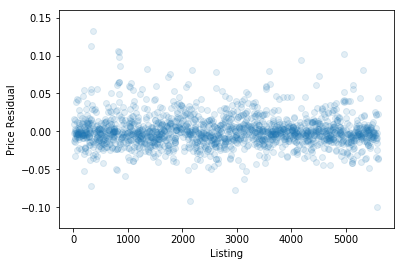

In [54]:
plot_residuals(X_test,y_test,test_predictions)

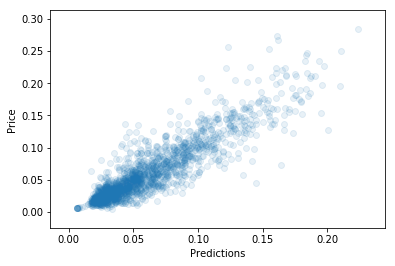

In [55]:
plot_predictions(y_test,test_predictions)

Now Redoing Linear and Nonlinear Regressions but this time with Interactions

In [56]:
def r2_est(X,y):
    linear_regression = linear_model.LinearRegression(normalize=True, fit_intercept=True)
    return r2_score(y, linear_regression.fit(X,y).predict(X))

In [57]:
def detect_interactions(X,y):
    
    #Baseline
    r2_impact = list()
    baseline = r2_est(X,y)
    for j in range(X.shape[1]):
        selection = [i for i in range(X.shape[1]) if i!=j]
        r2_impact.append(((r2_est(X,y)-(r2_est(X.values[:,selection],y)),X.columns[j])))
    
    #Interaction comparison vs Baseline
    create_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_i = create_interactions.fit_transform(X)
    main_effects = create_interactions.n_input_features_
    
    #Now calculating the interactions:
    a = []
    b = []
    inc = []
    
    for k, effect in enumerate(create_interactions.powers_[(main_effects):]):
        A, B = X.columns[effect==1]
        increment = r2_est(X_i[:,list(range(0,main_effects))+[main_effects+k]],y) - baseline
        if increment > 0.01:
            print ("Interaction: var %8s and var %8s R2: %5.3f" %(A,B,increment))
            a.append(A)
            b.append(B)
            inc.append(increment)
    
    increments = pd.DataFrame({
        "Var1":a,
        "Var2":b,
        "Increment": inc
    }, columns = ['Var1','Var2','Increment'])
    
    return increments

In [58]:
def add_interactions(X, increments):
    for i,k in zip(increments.Var1, increments.Var2):
        new_int_feature = str(i) + '*' + str(k)
        X[new_int_feature] = X[i] * X[k]
    return X

In [59]:
increments = detect_interactions(X_train,y_train)

Interaction: var accommodates and var bathrooms R2: 0.014
Interaction: var accommodates and var bedrooms R2: 0.016
Interaction: var accommodates and var     beds R2: 0.016
Interaction: var bathrooms and var bedrooms R2: 0.010
Interaction: var bathrooms and var     beds R2: 0.011
Interaction: var bathrooms and var park_count_3km R2: 0.011
Interaction: var bathrooms and var park_count_5km R2: 0.014
Interaction: var bedrooms and var     beds R2: 0.013
Interaction: var bedrooms and var events_within_5_km R2: 0.010
Interaction: var bedrooms and var park_count_5km R2: 0.011
Interaction: var availability_90 and var park_count_10km R2: 0.011
Interaction: var description_TextLength and var park_count_5km R2: 0.011
Interaction: var description_TextLength and var park_count_10km R2: 0.011
Interaction: var description_TextWordsPerc and var description_TextPuncPerc R2: 0.012
Interaction: var description_TextWordsPerc and var has_Essentials R2: 0.012
Interaction: var description_TextWordsPerc and va

Interaction: var zipcode_cleansed_enc and var park_count_16km R2: 0.017
Interaction: var is_location_exact_bin and var park_count_5km R2: 0.011
Interaction: var is_location_exact_bin and var park_count_10km R2: 0.012
Interaction: var host_has_profile_pic_bin and var distance_of_closest_park R2: 0.012
Interaction: var host_has_profile_pic_bin and var park_count_1km R2: 0.013
Interaction: var host_has_profile_pic_bin and var park_count_3km R2: 0.018
Interaction: var host_has_profile_pic_bin and var park_count_5km R2: 0.023
Interaction: var host_has_profile_pic_bin and var park_count_10km R2: 0.030
Interaction: var host_has_profile_pic_bin and var park_count_16km R2: 0.024
Interaction: var events_within_1_km and var events_within_3_km R2: 0.017
Interaction: var events_within_1_km and var events_within_5_km R2: 0.028
Interaction: var events_within_1_km and var park_count_3km R2: 0.011
Interaction: var events_within_1_km and var park_count_5km R2: 0.018
Interaction: var events_within_3_km a

In [60]:
X_train_intns = add_interactions(X_train, increments)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [61]:
scores_lin = cross_validate(lin_reg, X_train_intns, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [62]:
print 'Evaluation Metrics for Linear Regression with CV and Interactions Features: '
eval_metrics(scores_lin)

Evaluation Metrics for Linear Regression with CV and Interactions Features: 
Training R2 Mean:  0.9227852897190087
Validation R2 Mean:  0.8102679147481933
Validation R2 STdev:  0.1207796356380181
--
Training RMSE Mean:  0.012704126770175399
Validation RMSE Mean:  0.01986087996474557
Validation RMSE STdev:  0.0002515636627878542
--
Training MAE Mean:  0.00959423519427011
Validation MAE Mean:  0.011506276088924837
Validation MAE STdev:  0.0007334141324129977


In [63]:
test_predictions = lin_reg.predict(X_test)

In [64]:
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

Test R2:  0.8090483477871199
Test RMSE:  0.020310479354053057
Test MAE:  0.015282028825835833


Now doing nonlinear regressions with Interaction Features

In [65]:
def nonlinear_reg(X_train, y_train, deg):
    
    model = Pipeline([('poly', PolynomialFeatures(degree = deg, interaction_only=False)),
                       ('linear', linear_model.LinearRegression(normalize=False, fit_intercept=True))])

    model.fit(X_train, y_train)
    
    r2 = r2_score(predictions, y_test)
    mse = mean_squared_error(predictions, y_test)
    mae =  mean_absolute_error(predictions, y_test)
    rmse =  np.sqrt(mse)
    
    print 'Model Degree: ', deg
    print 'Test R2 Score: ', r2
    print 'Test MSE Score: ', mse
    print 'Test MAE Score: ', mae
    print 'Test RMSE Score: ', rmse
    
    return model, predictions, r2, mse, mae, rmse

In [66]:
model, predictions, r2, mse, mae, rmse = nonlinear_reg(X_train_intns, y_train, 2)
test_predictions = model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

KeyboardInterrupt: 

In [ ]:
model, predictions, r2, mse, mae, rmse = nonlinear_reg(X_train_intns, y_train, 3)
test_predictions = model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [149]:
import sys
sys.path.append('./lib')
from hello import print_hello

In [151]:
print_hello()

Hello!
